In [20]:
import numpy as np
import pattern_walker.inference.utils as utils
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pattern_walker as pw
from pattern_walker.mean_field import MF_patternWalker_general,MF_mfpt_cary_tree
import networkx as nx

from copy import deepcopy

import warnings
warnings.filterwarnings('ignore') # suppress warning for presentability

In [5]:
source = 'HousingAct.json'

In [6]:
data = utils.load_data(source)

In [7]:
# dictionary where all documents within the same part are stored in one "flat" list
parts_flat = utils.flat_parts_json(data)


In [8]:
# keyword parameters for preprocessing
instructions = {'analyzer':'words', 'ngram_range':(1,4),'norm':'l1','sublinear_tf':True}
vocabs = utils.get_vocabs(parts_flat,num_top_terms=100,**instructions)
    

In [9]:
estimators = {} #hold the parameters passed to patternWalker class later
#can also be solved with utils.get_mask_length once on a tree

estimators['pattern_len'] = len(vocabs[0]) # L
c = len(vocabs[2]) #number of parts
#estimate Delta
estimators['overlap'] = np.max([ (sum(p)-len(vocabs[0])/c)/2 for p in vocabs[2] ]) 
print(estimators)

{'pattern_len': 650, 'overlap': 3.5714285714285694}


In [10]:
# data dict with all text items replace by patterns under key "name"
vec_data = utils.vectorise_json(vocabs[0],data,binary=True)
# add binary vector to part nodes indicating topic-specific and generic keywords
for ndx,part in enumerate(vec_data['_children']):
    part['mask'] = vocabs[-1][ndx]
    

Power_divergenceResult(statistic=206.60692931734678, pvalue=3.557208439393673e-05)
Power_divergenceResult(statistic=0.08601682890853525, pvalue=1.0)


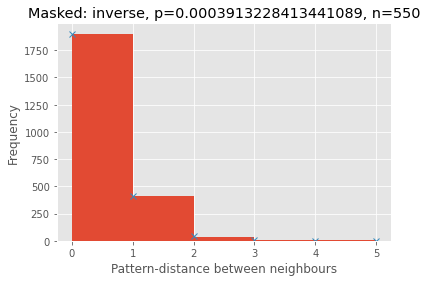

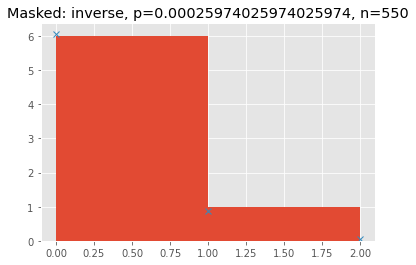

In [21]:

other_params={} #for standard deviations and other estimators not to be fed 
#into patternWalker class

#make a networkx.DiGraph from the dict
tree = utils.build_tree(vec_data,int_ids=True)
other_params['number of nodes'] = len(tree)
root=vec_data['node_id']

estimators['root']=root

# for convenience, add to each node a hint to which part it belongs
utils.add_part_attribute(vec_data,tree)

# list of nodes on part level...
part_nodes = [node['node_id'] for node in vec_data['_children'] ]
# ...and below part level
non_part_nodes = list(set(tree.nodes)-set(part_nodes)-set([root]))

# list of lists indicating part membership
parts = [
            [ node for node in non_part_nodes 
              if tree.nodes[node]['part']==part ] 
         for part in part_nodes]

# estimate a_h from topic-specific keyword presence (masked=True)...
temp_h = np.array(list(utils.estimate_a(tree,tree.nodes,masked=True)[1].values()))
# ... and a_l from generic keyword presence (masked='inverse')
temp_l = np.array(list(utils.estimate_a(tree,tree.nodes,masked='inverse')[1].values()))

# a_h is the mean of the above list
a_h = np.mean(temp_h)
sigma_h = np.sqrt(a_h*(1-a_h)/len(temp_h))
a_l = np.mean(temp_l)
sigma_l = np.sqrt(a_l*(1-a_l)/len(temp_l))

# estimate a_root as the difference between a_h and a_l
a_root,sigma_root = a_h-a_l, np.sqrt(abs(sigma_h**2+sigma_l**2))

# get next-neighbour distances in the tree, excluding part and root nodes. 
#'inverse' has most equidistributed bits
distances = utils.get_distances_to_parent(tree,masked='inverse',nodes=non_part_nodes) 
n=utils.get_mask_length(tree,nodes=non_part_nodes,masked='inverse')

p=np.mean([ distances[node]/n[node] for node in distances.keys() ])
sigma_p = p*(1-p)/len(distances)


# plot next-neighbour distances as histogram and compare to binomial
hist_data=utils.get_distance_histogram(tree,masked='inverse',nodes=non_part_nodes)
plt.xlabel('Pattern-distance between neighbours')
plt.ylabel('Frequency')

# same as above between part-level and root nodes
root_part_distances = utils.get_distances_to_parent(tree,masked='inverse',
                                                        nodes=part_nodes)
root_hist_data=utils.get_distance_histogram(tree,masked='inverse',nodes=part_nodes)

n_part = utils.get_mask_length(tree,part_nodes,'inverse')

p_p =  np.mean([ root_part_distances[node]/n_part[node] 
                for node in root_part_distances.keys() ] )
sigma_p_p = p_p*(1-p_p)/len(root_part_distances)


# save estimated parameters
estimators['a_high'] = a_h
estimators['a_low'] = a_l
estimators['a_root'] = a_root
estimators['Gamma']=p/(2*a_l*(1-a_l))
estimators['Gamma_root'] = (p_p-a_root+a_l)/(2*(1-a_root))

other_params['p']=p,sigma_p
other_params['p_p']=p_p,sigma_p_p

other_params['sigma_h'] = sigma_h
other_params['sigma_l'] = sigma_l
other_params['sigma_root']= sigma_root
other_params['sigma_Gamma']=\
            1/(2*a_l*(1-a_l))*np.sqrt(sigma_p**2+p**2*sigma_l**2*\
                                          (1-2*a_l)**2/(a_l**2*(1-a_l)**2))
other_params['sigma_Gamma_root'] =\
            2/(1-a_root)*np.sqrt(sigma_p_p**2+sigma_l**2+sigma_root**2/(1-a_root)**2)



In [12]:
estimators,other_params

({'pattern_len': 650,
  'overlap': 3.5714285714285694,
  'root': 0,
  'a_high': 0.0019097130823901027,
  'a_low': 0.0012321690184285603,
  'a_root': 0.0006775440639615424,
  'Gamma': 0.1574520636295045,
  'Gamma_root': 0.0003982386721382268},
 {'number of nodes': 2359,
  'p': (0.00038753700918737067, 1.6477533996336911e-07),
  'p_p': (0.00024131274131274132, 3.446492992480306e-05),
  'sigma_h': 0.0008990773893079629,
  'sigma_l': 0.0007224295716393701,
  'sigma_root': 0.0011533623185902451,
  'sigma_Gamma': 0.09220141508608323,
  'sigma_Gamma_root': 0.002725918432365252})

In [13]:
#print top-5 terms
for part in vocabs[1]:
    print(part[:5])
print('-----------')

['publish', 'premise landlord', 'tenant premise', 'reference premise', 'specified period day']
['exemption notice serve respect', 'date temporary exemption notice', 'temporary exemption notice serve', 'designation authority', 'person require pay']
['reference matter circumstance', 'financial penalty person respect', 'relevant award', 'time review operation designation', 'penalty alternative prosecution']
['planning include', 'letting', 'legal owner premise purpose', 'house right', 'local authority deal']
['supplementary', 'act estate agent', 'duty person act estate', 'person act estate agent', 'home information pack']
['relation agreement arrangement day', 'time deposit hold accordance', 'tenancy time deposit hold', 'tenancy require deposit consist', 'mobile home c. particular']
['apply converted block', 'household regulation', 'wale order connection', 'consent', 'premise effectively secure trespasser']
-----------


In [14]:
estimators['target'] = 226 # for reproducibility
print(estimators)

{'pattern_len': 650, 'overlap': 3.5714285714285694, 'root': 0, 'a_high': 0.0019097130823901027, 'a_low': 0.0012321690184285603, 'a_root': 0.0006775440639615424, 'Gamma': 0.1574520636295045, 'Gamma_root': 0.0003982386721382268, 'target': 226}


In [15]:
#store vectors under new name 'pattern' in tree...
pattern_tree = deepcopy(tree)
pattern_dict=nx.get_node_attributes(pattern_tree,'name')
for node,vector in pattern_dict.items():
    pattern_dict[node]=np.squeeze(vector)
nx.set_node_attributes(pattern_tree,pattern_dict,'pattern')
PW_emp = pw.empiricalPatternWalker(pattern_tree,root=estimators['root'],\
                                   target=estimators['target'])
PW_MF= MF_patternWalker_general(pattern_tree,**estimators)

In [16]:
#make a diffusive version too, in which all patterns are just 0
PW_diffusive = MF_patternWalker_general(pattern_tree,estimators['root'],\
                                        estimators['pattern_len'],0.,0.,0.,0.,0.,0.,\
                                        target=estimators['target']
                                       )

In [17]:
m_MF=pw.utils.mfpt(PW_MF,[(PW_MF.root,PW_MF.target_node)],weight_str='mean_weight',\
                   method='grounded_Laplacian')
print(m_MF,m_MF/len(PW_MF))

15712.192504210238 6.660530947100567


In [18]:
m_emp=pw.utils.mfpt(PW_emp,[(PW_emp.root,PW_emp.target_node)],weight_str='weight',\
                    method='grounded_Laplacian')
print(m_emp,m_emp/len(PW_emp))

22219.661904768953 9.419102121563778


In [19]:
m_diff=pw.utils.mfpt(PW_diffusive,[(PW_diffusive.root,
          PW_diffusive.target_node)],weight_str='weight',\
                     method='grounded_Laplacian')
print(m_diff,m_diff/len(PW_diffusive))

22243.000000010714 9.428995337011749
